# Example of a project done in IMEC 2320 / Transferencia de Calor (Heat Transfer)
The objective of this project is to solve for the shape of a thermal fin which produces the highest efficiency under certain restrictions. To solve this, the project is structured as follows:
1. Generate a function that can simulate the temperature profile within the thermal fin. (perfil de temperatura function)
2. Generate a function that can calculate the efficiency based on a fins thermal profile.
3. Apply Gradient Descent using the Efficiency as the functional and the height of the fin at various points as the independent variables.

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import integrate as integ 
def derivadaVector(y,i,L): 
    return ((y[i+1]-y[i-1])/(L/len(y))*2) 
def generaArea(y,w,B1): 
    n=len(y) 
    a=[] 
    for i in range(n): 
        yt=B1*(1-i/n)+abs(y[i]) 
        a.append(yt*w) 
    return a 
def generaPerimetro(y,w,B1): 
    n=len(y) 
    a=[] 
    for i in range(n): 
        yt=B1*(1-i/n)+abs(y[i]) 
        a.append(yt*2+w*2) 
    return a 
def GeneraMatriz(y,w,B1,L,k,h): 
    n=len(y)-1 
    p=generaPerimetro(y,w,B1) 
    a=generaArea(y,w,B1) 
    deltaX=L/n 
    matriz=[] 
    #Se genera la matriz para las primeras n-1 filas 
    for contadorExterno in range(n-1): 
        interna=[] 
        for contadorInterno in range(n): 
            i=contadorExterno+1 
            if(contadorInterno<contadorExterno-1): 
                interna.append(0) 
            elif (contadorInterno==contadorExterno-1): 
                interna.append(a[i]/deltaX/deltaX-derivadaVector(a,i,L)/deltaX/2) 
            elif (contadorInterno==contadorExterno): 
                interna.append(-h/k*p[i]-2*a[i]/deltaX/deltaX) 
            elif (contadorInterno==contadorExterno+1): 
                interna.append(a[i]/deltaX/deltaX+derivadaVector(a,i,L)/deltaX/2) 
            else: 
                interna.append(0) 
        matriz.append(interna) 
    #Se genera la fila n a partir de la condicion de frontera adiabatica 
    fila20=[] 
    for i in range(n-3): 
        fila20.append(0) 
    fila20.append(1) 
    fila20.append(-4) 
    fila20.append(3) 
    matriz.append(fila20) 
    return matriz 
def	perfilDeTemperatura(w,y,L,k,h,B1,theta): 
    n=len(y)-1 
    difX=L/n 
    a1=generaArea(y,w,B1) 
    condicionesFrontera=[-(theta)*a1[1]/difX/difX-derivadaVector(a1,1,L)/2/difX] 
    for i in range(n-1): 
        condicionesFrontera.append(0) 
    matrizgenerada=np.array(GeneraMatriz(y,w,B1,L,k,h)) 
    respuesta=[theta] 
    variableTemporal=np.linalg.solve(matrizgenerada,condicionesFrontera) 
    for i in range(len(variableTemporal)): 
        respuesta.append(variableTemporal[i]) 
    return respuesta 
def eficiencia(t,ySuperior,B1,w,h,x): 
    #Para encontrar la eficiencia primero se va a definir la temperatura máxima 
    p=generaPerimetro(ySuperior,w,B1) 
    qm=integ.simps(p,x)*t[0]*h 
    #generamos el vector que vamos a integrar 
    calor=[] 
    for i in range(len(t)): 
        calor.append((t[i]*p[i]*h)) 
    q=integ.simps(calor,x) 
    return (q/qm)*100 
 

#Evaluado para un perfil de alturas de nombre k 
#Se definen las variables iniciales 
w=1 # ancho del perfil 
#n es el numero de puntos que se va a utilizar 
n=60 
L=1 # largo de la aleta
k=10 #conductividad termica del material
h=2  # coeficiente de convección
theta=1 # diferencia de temperatura
B0=0.3 # base de la aleta.
y=np.linspace(B0,0,n) 
B1=0 
t=perfilDeTemperatura(w,y,L,k,h,B1,theta) 
#Se define el vector X, como el vector en el que ira cada punto. estos estan igualmente espaciados 
x=[] 
for i in range(len(y)): 
    x.append(i/(n-1)*L) 
#se va a generar un perfil de temperaturas ideal 
 
def derivadorParcial(yvec, iev, pert): 
    yvecprima= yvec.copy() 
    yvecprima[iev]= yvec[iev] + pert 
 
    TPrima = perfilDeTemperatura(w,yvecprima,L,k,h,B1,theta) 
    TNorm = perfilDeTemperatura(w,yvec,L,k,h,B1,theta) 
 
    eficienciaPrima = eficiencia(TPrima,yvecprima,B1,w,h,x) 
    eficienciaNorm = eficiencia(TNorm,yvec,B1,w,h,x) 
 
    resultado=(eficienciaPrima-eficienciaNorm)/pert 
    return (resultado) 
 
def vectorGradiente(yvec, pert,parada): 
    grad=[] 
    grad.append(0) 
    #Parada define el punto a partir del cual se va a dejar de calcular el vactor gradiente y se va a reemplazar por los numeros 
    #anteriores 
    for i in range(len(yvec)-1-parada): 
        j=i+1 
        grad.append(derivadorParcial(yvec,j,pert)) 
    for i in range(parada): 
        grad.append(grad[-1]) 
    return grad 
historicogradiente=[] 
historicoEficiencia=[eficiencia(perfilDeTemperatura(w,np.linspace(B0,B0,n),L,k,h,B1,theta),np.linspace(B0,B0,n),B1,w,h,x)] 

def optimizacion(pert,avance,iter,parada): 
    yopt=np.linspace(B0,B0,n) 
    for i in range(iter): 
        #Se declara un vector que tomara la forma que tomaría el vector al final de la iteracion  
        ypot=yopt.copy() 
        gradiente=vectorGradiente(yopt,pert,parada) 
        norma=np.linalg.norm(gradiente) 
        #El vector toma la forma final 
        for j in range(len(yopt)): 
            ypot[j]=yopt[j]+gradiente[j]*avance/norma 
        #Se encuentran los puntos en donde la altura es mas alta que b0. 
        indice = np.where(ypot>B0) 
        indiceR = indice[0] 
        #Se reemplaza el cambio de altura de estos puntos por cero. De esta forma los puntos se mantienen en un estado inicial correcto 
        for j in indiceR: 
            gradiente[j]= 0 
        #Se hace lo mismo para los puntos menores que 0 
        indice = np.where(ypot<0) 
        indiceR = indice[0] 
        for j in indiceR: 
            gradiente[j]= 0 
        #Finalmente se cambia el vector 
        norma=np.linalg.norm(gradiente) 
        for j in range(len(yopt)): 
            yopt[j]=yopt[j]+gradiente[j]*avance/norma 
        nuevaTemperatura=perfilDeTemperatura(w,yopt,L,k,h,B1,theta) 
        historicoEficiencia.append(eficiencia(nuevaTemperatura,yopt,B1,w,h,x)) 
    print(eficiencia(perfilDeTemperatura(w,yopt,L,k,h,B1,theta),yopt,B1,w,h,x)) 
    return yopt 
 
 
#El primer numero es la perturbacion, el segundo el avance, el tercero el numero de iteraciones 
#El cuarto numero es el punto a partir del cual se empieza a repetir el numero anterior 
optimizado=optimizacion(B0/100, B0/50, 190,1) 
topti=perfilDeTemperatura(w,optimizado,L,k,h,B1,theta) 
#Acá se grafica el perfil 
 


83.78695759143685


83.78695759143685


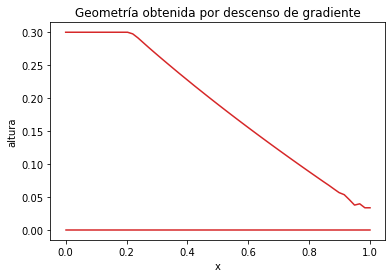

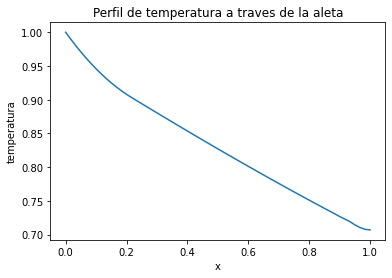

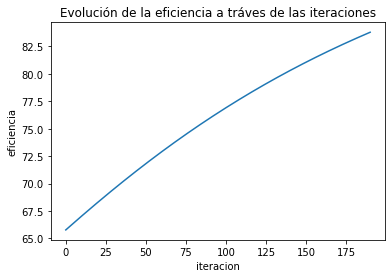

In [12]:

yinf=np.linspace(-B1,0,num=len(y)) 
fig, ax1 = plt.subplots() 
color = 'tab:red' 
ax1.set_xlabel('x') 
ax1.set_ylabel('altura') 
ax1.set_title('Geometría obtenida por descenso de gradiente')
ax1.plot(x, optimizado, color=color,label="Parte superior del perfil") 
ax1.plot(x, yinf, color=color,label="Parte inferior del perfil") 
 
fig, ax1 = plt.subplots() 
color = 'tab:blue' 
ax1.set_title('Perfil de temperatura a traves de la aleta')
ax1.set_xlabel('x') 
ax1.set_ylabel('temperatura') 
ax1.plot(x, topti,label="Gradiente") 
#ax1.tick_params(axis='y', labelcolor=color) 
 
 
fig, ax1 = plt.subplots() 
color = 'tab:blue' 
ax1.set_title('Evolución de la eficiencia a tráves de las iteraciones')
ax1.set_xlabel('iteracion') 
ax1.set_ylabel('eficiencia') 
ax1.plot(historicoEficiencia, color=color,label="Gradiente") 
#ax1.set_ylim([-50,50]) 
 
#ax1.tick_params(axis='y', labelcolor=color) 
plt.show 
print(eficiencia(topti,optimizado,B1,w,h,x)) 